# Pitch & Roll prediction w/Images

In [1]:
import gc
import os
import sys
import math
import pickle
import platform
import numpy as np
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pytorch_lightning as pl

In [2]:
current = os.path.dirname(os.path.realpath(''))
parent = os.path.dirname(current)
sys.path.append(parent)  

# del sys.modules["notebooks.data_loaders.data_module"]
from notebooks.data_loaders.utils import Utilities
from notebooks.data_loaders.splitter import DataSplitter
from notebooks.models.model_provider import ModelProvider
from notebooks.data_loaders.data_module import DataModule
from notebooks.data_loaders.data_loader import CustomDataLoader
from notebooks.models.model_provider import ModelProvider
from notebooks.data_loaders.sequence_generator import SequenceGenerator

In [3]:
print(torch.__version__)
print(pl.__version__)

1.11.0
1.6.1


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 16
Platform: windows
number of workers: 0


## Constants

In [18]:
# change to appropriate location
TRAIN_FOLDER = "../../3dmodel/test_4_episode_"
MODEL_NAME = "CNN_linear_img-to-PR"
MODEL_STATE_FOLDER = f"../model_states/{MODEL_NAME}"
RESULT_FOLDER = f"../../results/{MODEL_NAME}"
TRAIN_RESULT_FOLDER = f"../training_results/{MODEL_NAME}"
TEST_RESULT_FOLDER = f"../test_results/{MODEL_NAME}"

In [19]:
if not os.path.exists(MODEL_STATE_FOLDER):
    os.mkdir(MODEL_STATE_FOLDER)
if not os.path.exists(TRAIN_RESULT_FOLDER):
    os.mkdir(TRAIN_RESULT_FOLDER)
if not os.path.exists(TEST_RESULT_FOLDER):
    os.mkdir(TEST_RESULT_FOLDER)
if not os.path.exists(RESULT_FOLDER):
    os.mkdir(RESULT_FOLDER)

In [7]:
FRAMES_IN = 10
FRAMES_OUT = 60

N_EPISODES = 10
FRAMES_PER_EPISODE = 400

TRAIN_SIZE = 0.8
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

CUDA = device.type == 'cuda'

# determines whether to save plots and if all tests should be run
SAVE = False
RUN_TESTS = True

## Load data from episodes

In [8]:
if RUN_TESTS:    
    dl = CustomDataLoader(TRAIN_FOLDER, N_EPISODES, load_images=True)
    dl.pr_data.shape, dl.image_tensor.shape

## Create input and output sequences

In [9]:
if RUN_TESTS:    
    all_sequences = SequenceGenerator.create_img_to_PR_sequences(dl.pr_data, dl.image_tensor, FRAMES_IN, FRAMES_OUT, FRAMES_PER_EPISODE, N_EPISODES)
    # total nr of sequences, first input sequence shape, first output sequence shape
    len(all_sequences), all_sequences[0][0].shape , all_sequences[0][1].shape

## Split data

In [10]:
if RUN_TESTS:    
    train_sequences, test_sequences = DataSplitter.split_sequences(all_sequences, TRAIN_SIZE)
    print(train_sequences[0][0].shape, train_sequences[0][1].shape)
    print(test_sequences[0][0].shape, test_sequences[0][1].shape)

Training size: 2648 | Test size: 662
torch.Size([10, 3, 54, 96]) (2, 60)
torch.Size([10, 3, 54, 96]) (2, 60)


## Pytorch Dataset and DataLoader

In [11]:
if RUN_TESTS:    
    # type = 3 for img to PR dataset
    data_module = DataModule(train_sequences, test_sequences, BATCH_SIZE, N_WORKERS, type=3)
    data_module.setup()

In [13]:
if RUN_TESTS:    
    # batch size first
    for batch in data_module.train_dataloader():
        x_train = batch["input"]
        y_train = batch["output"]
        break

    print(x_train.shape, y_train.shape)

torch.Size([64, 10, 3, 54, 96]) torch.Size([64, 2, 60])


## CNN Model

In [15]:
if RUN_TESTS:    
    model = ModelProvider.cnn_linear(FRAMES_IN, FRAMES_OUT)
    out = model.forward(x_train)
    print(out.shape)

torch.Size([64, 2, 60])


## Load model state

In [20]:
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
loaded_model = ModelProvider.cnn_linear(FRAMES_IN, FRAMES_OUT)
loaded_model.load_state_dict(torch.load(filename))
if CUDA: 
    loaded_model = loaded_model.cuda()
loaded_model.eval()

CNN_linear(
  (cnn_encoder): CNN_encoder(
    (cnn_encoder): Sequential(
      (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (linear): Linear(
    (fc1): Linear(in_features=23040, out_features=4096, bias=True)
    (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=120, bias=True)
  )
)

# Training results

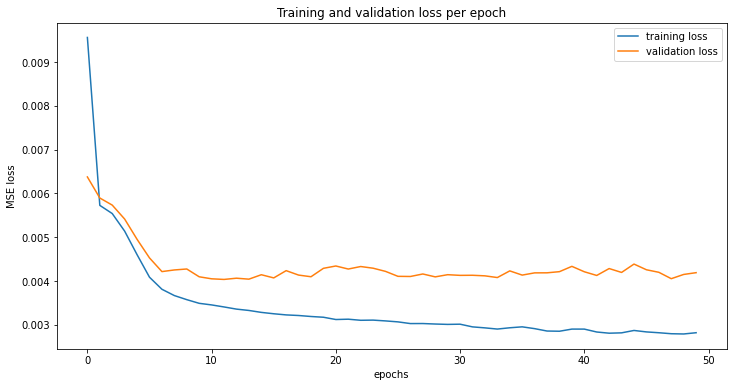

In [21]:
plt.figure(figsize=(12, 6))
with open(f'{TRAIN_RESULT_FOLDER}/train_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs', 'rb') as f:
    train_losses_epoch = pickle.load(f)
with open(f'{TRAIN_RESULT_FOLDER}/val_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs', 'rb') as f:
    val_losses_epoch = pickle.load(f)
plt.plot(range(NUM_EPOCHS), train_losses_epoch, label='training loss')
plt.plot(range(NUM_EPOCHS), val_losses_epoch, label='validation loss')
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.title("Training and validation loss per epoch")
plt.legend()
if SAVE:
    plt.savefig(f'{RESULT_FOLDER}/train-test-loss_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

# Testing

In [22]:
if RUN_TESTS:    
    # get first I/O-sequence of test dataset for visualizing a prediction
    for batch in data_module.test_dataloader():
        x_test = batch["input"]
        y_test = batch["output"]
        break

    if CUDA:
        x_test = x_test.cuda()
        y_test = y_test.cuda()

    print(x_test.shape, y_test.shape)

torch.Size([1, 10, 3, 54, 96]) torch.Size([1, 2, 60])


In [17]:
if RUN_TESTS:    
    criterion = nn.MSELoss()

    # make one prediction for visualization
    with torch.no_grad():
        y_pred = loaded_model(x_test.squeeze(1))
        loss = criterion(y_pred, y_test)

        # clean up tensor and round results to visually compare predicted sequence
        a = y_pred.squeeze(0)[0].tolist()
        a = [round(num, 4) for num in a]

        b = y_test.squeeze(0)[0].tolist()
        b = [round(num, 4) for num in b]

        print(f'predicted pitch: {a}\nreal pitch:\t {b}')
        print("loss:", round(loss.item(), 6))

    # squeeze out batch size and convert into cpu format for plotting
    x_test.squeeze(0).shape
    input_sequence = x_test.squeeze(0).cpu()
    output_sequence = y_test.squeeze(0).cpu()
    predicted_sequence = y_pred.squeeze(0).cpu()
    input_sequence.shape, output_sequence.shape, predicted_sequence.shape

### Prediction vs. real on first test I/O-sequence

In [18]:
if RUN_TESTS:     
    frames = np.arange(0,FRAMES_OUT)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(output_sequence[0].apply_(Utilities.denorm_pr), label="real")
    ax.plot(predicted_sequence[0].apply_(Utilities.denorm_pr), color="red", label='predicted')
    ax.set_xlabel('frames')
    ax.set_ylabel('pitch (°)')
    ax.set_title(f'CNNN LSTM {FRAMES_IN} to {FRAMES_OUT} prediction results')
    plt.legend()
    if SAVE:
        plt.savefig(f'{RESULT_FOLDER}/1ep_pitch-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
    plt.show()

In [19]:
if RUN_TESTS: 
    frames = np.arange(0,FRAMES_OUT)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(output_sequence[1].apply_(Utilities.denorm_pr), label="real")
    ax.plot(predicted_sequence[1].apply_(Utilities.denorm_pr), color="red", label='predicted')
    ax.set_xlabel('frames')
    ax.set_ylabel('roll (°)')
    ax.set_title(f'CNN LSTM {FRAMES_IN} to {FRAMES_OUT} prediction results')
    plt.legend()
    if SAVE:
        plt.savefig(f'{RESULT_FOLDER}/1ep_roll-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
    plt.show()

### Inference time

In [20]:
if RUN_TESTS: 
    total, inference = Utilities.inference_time(loaded_model, x_test, repetitions=10000)
    print(f"total execution time for 10.000 predictions: {np.sum(total)}")
    print(f"Inference time for 10.000 predictions:\t {inference}")

    sum = 0
    for p in loaded_model.parameters():
        sum += p.numel()

    print(f"Total trainable parameters:\t {sum}")

In [21]:
if RUN_TESTS:     
    plt.figure(figsize=(10,5))
    plt.plot(total)
    plt.ylabel("time (s)")
    plt.xlabel("number of predictions")
    plt.title("Inference time for single-step model")
    if SAVE:
        plt.savefig(f'{RESULT_FOLDER}/inference_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}', bbox_inches='tight')
    plt.show()

### Full test loop

In [22]:
if RUN_TESTS:     
    predictions = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(data_module.test_dataloader()):
            x_test = batch["input"]
            y_test = batch["output"]

            if CUDA:
                x_test = x_test.cuda()

            output = loaded_model(x_test.squeeze(1))

            # squeeze out batch size which is = 1 for test dataset
            predictions.append(output.cpu().squeeze(0))
            labels.append(y_test.squeeze(0))

In [23]:
if RUN_TESTS:     
    # Predictions[0] = tensor object
    # Predictions[0][0] = pitch value
    # Predictions[0][1] = roll value

    pitch_predictions = []
    roll_predictions = []

    pitch_label = []
    roll_label = []

    for i in range(len(predictions)):
        pitch_predictions.append(predictions[i][0])
        roll_predictions.append(predictions[i][1])
        pitch_label.append(labels[i][0])
        roll_label.append(labels[i][1])

    pitch_predictions[0].shape, roll_predictions[0].shape, pitch_label[0].shape, roll_label[0].shape

### Average loss-per-frame over all datapoints

In [24]:
# function that returns a list with loss-values per frame
def loss_per_frame(predicted_sequence, real_sequence):
    loss_per_frame = []
    criterion = nn.MSELoss()
    if predicted_sequence.shape != real_sequence.shape:
        return loss_per_frame
    for i in range(len(predicted_sequence)):
        loss = criterion(predicted_sequence[i], real_sequence[i])
        loss_per_frame.append(loss.item())
    return loss_per_frame

In [25]:
if RUN_TESTS: 
    # calculate mean loss per frame over all test data
    total = len(pitch_predictions)
    pitch_total = np.zeros(FRAMES_OUT, dtype=np.float64)
    roll_total = np.zeros(FRAMES_OUT, dtype=np.float64)

    for i in tqdm(range(len(pitch_predictions))):
        pitch_lpf = loss_per_frame(pitch_predictions[i], pitch_label[i])
        roll_lpf = loss_per_frame(roll_predictions[i], roll_label[i])
        pitch_total += pitch_lpf
        roll_total += roll_lpf

    pitch_lpf_mse = pitch_total / total
    roll_lpf_mse = roll_total / total

In [26]:
if RUN_TESTS:     
    pitch_lpf_rmse = np.sqrt(pitch_lpf_mse)
    roll_lpf_rmse = np.sqrt(roll_lpf_mse)
    denorm = lambda x: Utilities.denorm_pr(x)
    vfunc = np.vectorize(denorm)
    plt.figure(figsize=(12, 5))
    plt.plot(vfunc(pitch_lpf_rmse), label='pitch')
    plt.plot(vfunc(roll_lpf_rmse), color='orange', label='roll')
    plt.xlabel('predicted frame')
    plt.ylabel('Denormalized RMSE Loss (°)')
    plt.title('Loss per frame: denormalized RMSE')
    plt.legend()
    if SAVE:
        plt.savefig(f'{RESULT_FOLDER}/LPF-denorm-RMSE_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
    plt.show()

### MSE results pitch

In [27]:
if RUN_TESTS:     
    n = len(pitch_predictions)
    loss0_tensor = torch.zeros(FRAMES_OUT)
    criterion = nn.MSELoss()

    loss = []
    loss0 = []

    total = 0
    total0 = 0

    for i in range(n):
        error = criterion(pitch_label[i], pitch_predictions[i]).item()
        error0 = criterion(pitch_label[i], loss0_tensor).item()
        loss.append(Utilities.denorm_pr(math.sqrt(error)))
        loss0.append(Utilities.denorm_pr(math.sqrt(error)))
        total += error
        total0 += error0
        

    mse = round(total/n, 5)
    rmse = round(math.sqrt(total/n), 4)
    mse0 = round(total0/n, 5)
    rmse0 = round(math.sqrt(total0/n), 4)

    if SAVE:
        np.save(f"{TEST_RESULT_FOLDER}/pitch_denormalized_error", loss)
        np.save(f"{TEST_RESULT_FOLDER}/pitch_zero_error", loss0)

    print("Pitch prediction")
    print("   MSE:", mse)
    print("   RMSE:", rmse)
    print(f"   RMSE denorm: {round(Utilities.denorm_pr(rmse), 2)}°")
    print("Zero prediction")
    print("   MSE 0:", mse0)
    print("   RMSE 0:", rmse0)
    print(f"   RMSE denorm: {round(Utilities.denorm_pr(rmse0), 2)}°")
    print("Improvement on zero prediction:")
    print("   MSE delta%:", round(mse0/mse*100, 2), "%")
    print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

### MSE results roll

In [28]:
if RUN_TESTS:     
    n = len(pitch_predictions)
    loss0_tensor = torch.zeros(FRAMES_OUT)
    criterion = nn.MSELoss()

    loss = []
    loss0 = []

    total = 0
    total0 = 0

    for i in range(n):
        error = criterion(roll_label[i], roll_predictions[i]).item()
        error0 = criterion(roll_label[i], loss0_tensor).item()
        loss.append(Utilities.denorm_pr(math.sqrt(error)))
        loss0.append(Utilities.denorm_pr(math.sqrt(error)))
        total += error
        total0 += error0
        

    mse = round(total/n, 5)
    rmse = round(math.sqrt(total/n), 4)
    mse0 = round(total0/n, 5)
    rmse0 = round(math.sqrt(total0/n), 4)

    if SAVE:
        np.save(f"{TEST_RESULT_FOLDER}/roll_denormalized_error", loss)
        np.save(f"{TEST_RESULT_FOLDER}/roll_zero_error", loss0)

    print("Roll prediction")
    print("   MSE:", mse)
    print("   RMSE:", rmse)
    print(f"   RMSE denorm: {round(Utilities.denorm_pr(rmse), 2)}°")
    print("Zero prediction")
    print("   MSE 0:", mse0)
    print("   RMSE 0:", rmse0)
    print(f"   RMSE denorm: {round(Utilities.denorm_pr(rmse0), 2)}°")
    print("Improvement on zero prediction:")
    print("   MSE delta%:", round(mse0/mse*100, 2), "%")
    print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

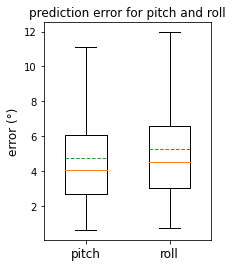

In [23]:
fig, ax = plt.subplots(figsize=(3,4))
pitch_error = np.load(f"{TEST_RESULT_FOLDER}/pitch_denormalized_error.npy")
roll_error = np.load(f"{TEST_RESULT_FOLDER}/roll_denormalized_error.npy")
ax.boxplot([pitch_error, roll_error], showfliers=False, widths=(0.5), showmeans=True, meanline=True)
ax.set_ylabel("error (°)", fontsize=12)
ax.set_xticks([1,2], ["pitch", "roll"], fontsize=12)
ax.set_title("prediction error for pitch and roll", fontsize=12)
if SAVE:
    plt.savefig(f'{RESULT_FOLDER}/error_boxplot_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}', bbox_inches='tight')